https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [1]:
sample_or_prod = False #True = sample, False = production
batch_size=64

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [2]:
cat_desc = ['safe driving', 'texting - right', 'talking on the phone - right', 
            'texting - left', 'talking on the phone - left', 'operating the radio', 
            'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
print ("cat_desc:", type(cat_desc), len(cat_desc))

('cat_desc:', <type 'list'>, 10)


In [3]:
HOMEPATH = "/home/ubuntu/fastai/"
DATA_PATH = HOMEPATH + "data/state/"
print("HOMEPATH:", HOMEPATH)
print("DATA_PATH:", DATA_PATH)
import os
from __future__ import division, print_function


('HOMEPATH:', '/home/ubuntu/fastai/')
('DATA_PATH:', '/home/ubuntu/fastai/data/state/')


In [4]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile
import pandas as pd
import numpy as np
import random
import cv2

In [5]:
MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)

WORKING_DATA: /home/ubuntu/fastai/data/state/
WORKING_TEST: /home/ubuntu/fastai/data/state/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/state/train/
WORKING_VALID: /home/ubuntu/fastai/data/state/valid/
s_or_p: _prod_


In [6]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/state
.
├── models
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── c0
│   │   ├── c1
│   │   ├── c2
│   │   ├── c3
│   │   ├── c4
│   │   ├── c5
│   │   ├── c6
│   │   ├── c7
│   │   ├── c8
│   │   └── c9
│   └── valid
│       ├── c0
│       ├── c1
│       ├── c2
│       ├── c3
│       ├── c4
│       ├── c5
│       ├── c6
│       ├── c7
│       ├── c8
│       └── c9
├── test
│   └── unknown
├── train
│   ├── c0
│   ├── c1
│   ├── c2
│   ├── c3
│   ├── c4
│   ├── c5
│   ├── c6
│   ├── c7
│   ├── c8
│   └── c9
└── valid
    ├── c0
    ├── c1
    ├── c2
    ├── c3
    ├── c4
    ├── c5
    ├── c6
    ├── c7
    ├── c8
    └── c9

51 directories


In [7]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]


In [8]:
CATEGORIES = []


for i in range(10):
    CATEGORIES.append("c"+str(i)+"/")
print ("CATEGORIES:", CATEGORIES)

CATEGORIES: ['c0/', 'c1/', 'c2/', 'c3/', 'c4/', 'c5/', 'c6/', 'c7/', 'c8/', 'c9/']


In [9]:
UNKNOWN = 'unknown/'

DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)

In [10]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, ", len(weights)", len(layer.get_weights()), "\n")
        count +=1

In [11]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [12]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))
        
#NB: could have used global DATA_DIR_LIST  to access global variable DATA_DIR_LIST 
# without having to pass DATA_DIR_LIST as an arg, but this gives more flexability.

In [13]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/state/ 5
/home/ubuntu/fastai/data/state/models/ 0
/home/ubuntu/fastai/data/state/results/ 2
/home/ubuntu/fastai/data/state/sample/ 0
/home/ubuntu/fastai/data/state/sample/test/ 0
/home/ubuntu/fastai/data/state/sample/test/unknown/ 15945
/home/ubuntu/fastai/data/state/sample/train/ 0
/home/ubuntu/fastai/data/state/sample/train/c0/ 347
/home/ubuntu/fastai/data/state/sample/train/c1/ 314
/home/ubuntu/fastai/data/state/sample/train/c2/ 323
/home/ubuntu/fastai/data/state/sample/train/c3/ 325
/home/ubuntu/fastai/data/state/sample/train/c4/ 323
/home/ubuntu/fastai/data/state/sample/train/c5/ 322
/home/ubuntu/fastai/data/state/sample/train/c6/ 324
/home/ubuntu/fastai/data/state/sample/train/c7/ 278
/home/ubuntu/fastai/data/state/sample/train/c8/ 268
/home/ubuntu/fastai/data/state/sample/train/c9/ 298
/home/ubuntu/fastai/data/state/sample/valid/ 0
/home/ubuntu/fastai/data/state/sample/valid/c0/ 153
/home/ubuntu/fastai/data/state/sample/valid/c1/ 138
/home/ubuntu/fastai/

In [14]:
os.chdir(HOMEPATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

current working directory: /home/ubuntu/fastai


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [15]:
batches = get_batches(WORKING_TRAIN, batch_size=batch_size)
val_batches = get_batches(WORKING_VALID, batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(WORKING_TEST, batch_size=1, shuffle=False)
print (WORKING_TRAIN, type(batches))
print (WORKING_VALID, type(val_batches))
print (WORKING_TEST, type(test_batches))


#https://keras.io/preprocessing/image/
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#NB: utils.get_batches has default target_size=(224,224)

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
/home/ubuntu/fastai/data/state/train/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/valid/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/test/ <class 'keras.preprocessing.image.DirectoryIterator'>


In [16]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filename) = get_classes(WORKING_DATA)
print ("val_classes", type(val_classes), val_classes.shape)
print ("trn_classes", type(trn_classes), trn_classes.shape)
print ("val_labels", type(val_labels), val_labels.shape)
print ("trn_labels", type(trn_labels), trn_labels.shape)
print ("val_filenames", type(val_filenames), len(val_filenames))
print ("filenames", type(filenames), len(filenames))
print ("test_filename", type(test_filename), len(test_filename))

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
val_classes <type 'numpy.ndarray'> (6740,)
trn_classes <type 'numpy.ndarray'> (15684,)
val_labels <type 'numpy.ndarray'> (6740, 10)
trn_labels <type 'numpy.ndarray'> (15684, 10)
val_filenames <type 'list'> 6740
filenames <type 'list'> 15684
test_filename <type 'list'> 79726


In [17]:
print ("test_filename[0]", test_filename[0])

test_filename[0] unknown/img_46339.jpg


In [18]:
print ("val_classes:", type(val_classes[0]), val_classes[0], np.unique(val_classes))
print ("trn_classes:", type(trn_classes[0]), trn_classes[0], np.unique(trn_classes))
print ("val_labels:", type(val_labels[0]), val_labels[0], np.unique(val_labels))
print ("trn_labels:", type(trn_labels[0]), trn_labels[0], np.unique(trn_labels))

val_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
trn_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
val_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]
trn_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]


In [19]:
temp_path = TRAIN_PATH+CATEGORIES[0]
print ("temp_path:", temp_path)
files = dirFileList(temp_path)

image_sizes = set([])
for i in range(len(files)):
    img_shape = cv2.imread(temp_path+files[i]).shape
    #print ("i:", i, ":", img_shape)
    image_sizes.add(img_shape)
print ("image_sizes:", image_sizes)
print ("No. of disctinct image sizes:", len(image_sizes))

temp_path: /home/ubuntu/fastai/data/state/train/c0/
image_sizes: set([(480, 640, 3)])
No. of disctinct image sizes: 1


model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

In [20]:
#model.summary()

In [21]:
#showLayersInfo(model)

In [22]:
#type(batches), type(batches.nb_sample)

In [23]:
#model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
#                 nb_val_samples=val_batches.nb_sample)

In [24]:
#plot_history(history)

In [25]:
#batches.n

In [26]:
#type(batches) = keras.preprocessing.image.DirectoryIterator
#recall : batches = get_batches(WORKING_TRAIN_PATH, batch_size=batch_size)
#Found 3122 images belonging to 10 classes.
#predicted = model.predict_generator(batches, batches.n)

In [27]:
#print ("predicted:", type(predicted), predicted.shape)


In [28]:
#np.round(predicted[:10],2)

pred = []
for i in range(predicted.shape[0]):
    #print (predicted[i], type(list(predicted[i])), np.argmax(predicted[i]))
    pred.append(np.argmax(predicted[i]))
print (set(pred))
#1st attempt: results show only index position 1 was predicted. obviously model is inadequate.
#end attempt: only 4 of the 10 classes predicted.  obviously model is inadequate.

model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

In [29]:
#plot_history(history)

model.optimizer.lr=0.001
history = model.fit_generator(  batches, 
                                batches.nb_sample, 
                                nb_epoch=6, 
                                validation_data=val_batches, 
                                nb_val_samples=val_batches.nb_sample)

In [30]:
#plot_history(history)

In [31]:
#predicted = model.predict_generator(batches, batches.n)

pred = []
for i in range(predicted.shape[0]):
    #print (predicted[i], type(list(predicted[i])), np.argmax(predicted[i]))
    pred.append(np.argmax(predicted[i]))
print ("No. of different classes predicted : ", len(list(set(pred))))
#10 different classes predicted. This is better.

In [32]:
rnd_batches = get_batches(WORKING_VALID, batch_size=batch_size*2, shuffle=True)

Found 6740 images belonging to 10 classes.


In [33]:
#val_res = [model.evaluate_generator(rnd_batches, rnd_batches.nb_sample) for i in range(10)]
#np.round(val_res, 2)

In [34]:
#type(val_res), type(val_res[0])

In [35]:
#print ("max:", max(list(np.array(val_res)[:,1])), ", min:", min(list(np.array(val_res)[:,1])))

In [36]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])
#https://keras.io/layers/core/#dense
#https://keras.io/regularizers/
#

In [37]:
model.summary()

#previous model without W_regularizer=l2(0.01)
#Total params: 1,505,302
#Trainable params: 1,505,296
#Non-trainable params: 6
#this model has exact same total params vs trainable params vs non-trainable params.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 3, 224, 224)   12          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 150528)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            1505290     flatten_1[0][0]                  
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
____________________________________________________________________________________________________


In [38]:
startTime= datetime.now()
print ("startTime:", startTime)


model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit_generator(batches, 
                              batches.nb_sample, 
                              nb_epoch=4, 
                              validation_data=val_batches, 
                              nb_val_samples=val_batches.nb_sample)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

Epoch 1/4
15684/15684 [==============================] - 289s - loss: 2.6336 - acc: 0.7179 - val_loss: 2.0725 - val_acc: 0.8381
Epoch 2/4
15684/15684 [==============================] - 259s - loss: 1.9643 - acc: 0.8710 - val_loss: 1.9626 - val_acc: 0.8687
Epoch 3/4
15684/15684 [==============================] - 260s - loss: 1.9437 - acc: 0.8725 - val_loss: 2.1759 - val_acc: 0.7947
Epoch 4/4
15684/15684 [==============================] - 259s - loss: 2.0144 - acc: 0.8581 - val_loss: 1.9504 - val_acc: 0.8634


['acc', 'loss', 'val_acc', 'val_loss']


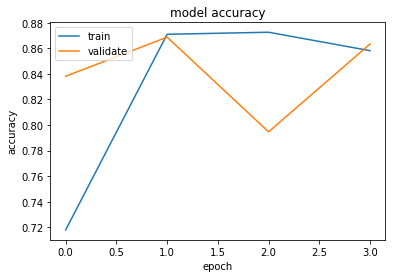

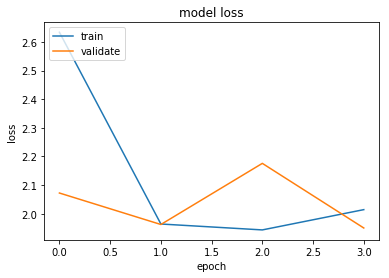

In [39]:
plot_history(history1)

In [40]:
startTime= datetime.now()
print ("startTime:", startTime)

model.optimizer.lr=0.001
history2 = model.fit_generator(batches, 
                               batches.nb_sample, 
                               nb_epoch=4, 
                               validation_data=val_batches, 
                               nb_val_samples=val_batches.nb_sample)
#https://keras.io/models/sequential/#sequential-model-methods
#
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

Epoch 1/4
15684/15684 [==============================] - 268s - loss: 1.8803 - acc: 0.8914 - val_loss: 1.8815 - val_acc: 0.8855
Epoch 2/4
15684/15684 [==============================] - 257s - loss: 1.8634 - acc: 0.8882 - val_loss: 1.9324 - val_acc: 0.8654
Epoch 3/4
15684/15684 [==============================] - 258s - loss: 1.9152 - acc: 0.8698 - val_loss: 1.9486 - val_acc: 0.8662
Epoch 4/4
15684/15684 [==============================] - 258s - loss: 1.9305 - acc: 0.8698 - val_loss: 1.8928 - val_acc: 0.8815


['acc', 'loss', 'val_acc', 'val_loss']


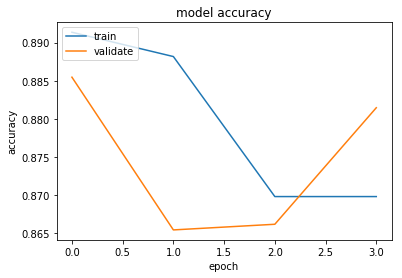

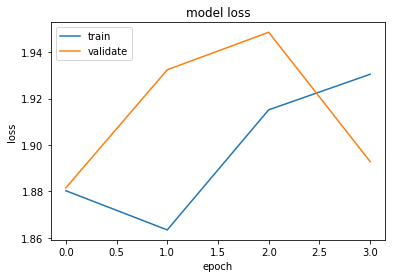

In [41]:
plot_history(history2)

In [42]:
startTime= datetime.now()
print ("startTime:", startTime)

val_res = [model.evaluate_generator(rnd_batches, rnd_batches.nb_sample) for i in range(10)]

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

np.round(val_res, 2)

array([[ 1.89,  0.88],
       [ 1.88,  0.88],
       [ 1.92,  0.88],
       [ 1.88,  0.88],
       [ 1.93,  0.88],
       [ 1.88,  0.88],
       [ 1.88,  0.88],
       [ 1.82,  0.89],
       [ 1.97,  0.88],
       [ 1.86,  0.88]])

In [43]:
print ("max:", max(list(np.array(val_res)[:,1])), ", min:", min(list(np.array(val_res)[:,1])))
#difference between max min shows stability of the prediction.

max: 0.885905044758 , min: 0.876261127313


In [44]:
startTime= datetime.now()
print ("startTime:", startTime)

test_feat = model.predict_generator(test_batches, test_batches.nb_sample)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime: 2018-01-04 08:21:15.664056
Time elapsed (hh:mm:ss.ms) 0:16:28.467144


In [45]:
type(test_feat), test_feat.shape, test_batches.nb_sample

(numpy.ndarray, (79726, 10), 79726)

In [46]:
test_feat[0:5,]

array([[  4.9437e-09,   1.6899e-04,   2.5404e-15,   4.8360e-05,   4.5700e-03,   5.5841e-08,
          4.8040e-01,   2.2150e-11,   5.1481e-01,   1.1001e-05],
       [  9.2481e-11,   1.1934e-06,   2.5105e-22,   7.4714e-12,   1.9818e-02,   2.9117e-07,
          3.6353e-01,   6.1665e-01,   2.2050e-12,   1.7889e-12],
       [  4.6553e-07,   6.5130e-09,   1.3993e-16,   2.1626e-05,   1.8428e-01,   3.3008e-05,
          2.1448e-05,   4.1512e-07,   8.1564e-01,   2.9755e-07],
       [  6.4233e-05,   2.2153e-11,   3.0051e-23,   9.9993e-01,   3.0792e-09,   3.2502e-13,
          1.1745e-12,   5.1908e-12,   9.9549e-12,   2.8712e-06],
       [  6.5191e-03,   2.9608e-05,   1.9350e-14,   1.1082e-07,   1.4381e-05,   2.8282e-01,
          4.6478e-01,   1.7952e-04,   2.4545e-01,   2.1469e-04]], dtype=float32)

In [49]:
#preds = model.predict(test, batch_size=batch_size)
preds = test_feat

In [50]:
print (type(preds), preds.shape)
print (preds[0:5, ])

<type 'numpy.ndarray'> (79726, 10)
[[  4.9437e-09   1.6899e-04   2.5404e-15   4.8360e-05   4.5700e-03   5.5841e-08   4.8040e-01
    2.2150e-11   5.1481e-01   1.1001e-05]
 [  9.2481e-11   1.1934e-06   2.5105e-22   7.4714e-12   1.9818e-02   2.9117e-07   3.6353e-01
    6.1665e-01   2.2050e-12   1.7889e-12]
 [  4.6553e-07   6.5130e-09   1.3993e-16   2.1626e-05   1.8428e-01   3.3008e-05   2.1448e-05
    4.1512e-07   8.1564e-01   2.9755e-07]
 [  6.4233e-05   2.2153e-11   3.0051e-23   9.9993e-01   3.0792e-09   3.2502e-13   1.1745e-12
    5.1908e-12   9.9549e-12   2.8712e-06]
 [  6.5191e-03   2.9608e-05   1.9350e-14   1.1082e-07   1.4381e-05   2.8282e-01   4.6478e-01
    1.7952e-04   2.4545e-01   2.1469e-04]]


In [51]:
preds = np.around(preds, decimals=1)
preds[0:5,]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.4,  0.6,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0.8,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.3,  0.5,  0. ,  0.2,  0. ]], dtype=float32)

In [52]:
test_filename[0:5], len(test_filename)

(['unknown/img_46339.jpg',
  'unknown/img_18865.jpg',
  'unknown/img_23088.jpg',
  'unknown/img_92913.jpg',
  'unknown/img_82508.jpg'],
 79726)

In [54]:
#create list of filenames with the unknown/ dropped
filenames = []
for i in range(len(test_filename)):
    filenames.append(test_filename[i][8:])
    #print (filenames[i])
print (filenames[0:5])

['img_46339.jpg', 'img_18865.jpg', 'img_23088.jpg', 'img_92913.jpg', 'img_82508.jpg']


In [55]:
filenames_array = np.reshape(np.array(filenames), (len(filenames),1))
filenames_array.shape

(79726, 1)

In [56]:
preds.shape

(79726, 10)

In [57]:
results2 = pd.concat([pd.DataFrame(filenames),pd.DataFrame(preds)],axis=1)

In [58]:
results2.shape

(79726, 11)

In [59]:
CATEGORIES
categories_ = []
for categ in CATEGORIES:
    #print (categ[0:2])
    categories_.append(categ[0:2])
categories_

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [60]:
results2.columns = ['img']+categories_

In [61]:
list(results2)

['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [62]:
results2.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_46339.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
1,img_18865.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.6,0.0,0.0
2,img_23088.jpg,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.8,0.0
3,img_92913.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,img_82508.jpg,0.0,0.0,0.0,0.0,0.0,0.3,0.5,0.0,0.2,0.0


#submit.csv example format.

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [63]:
RESULTS_PATH

'/home/ubuntu/fastai/data/state/results/'

In [64]:
%cd $RESULTS_PATH
submission_file_name = "submit"+ s_or_p +".csv"
results2.to_csv(submission_file_name, index=False, float_format='%.1f')
print ("written to :", submission_file_name)

/home/ubuntu/fastai/data/state/results
written to : submit_prod_.csv


'texting - left'

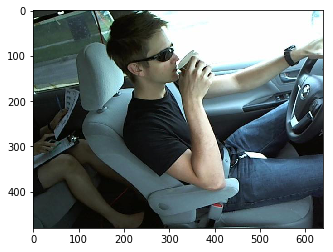

In [66]:
import matplotlib.image as mpimg
img=mpimg.imread(WORKING_TEST+UNKNOWN + filenames[0])
imgplot = plt.imshow(img)
results2.head(1)
cat_desc[3]

In [67]:
#results2.shape
#NB: must have 79726 rows

#cd ~/fastai/data/state/results
#kg submit  submit_sample_.csv -u -user-email- -p -password- -c state-farm-distracted-driver-detection


In [68]:
results2.shape

(79726, 11)

In [69]:
list(results2)

['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [70]:
results2.img.unique().shape

(79726,)

In [71]:
len(test_filename)
#NB: shape of results2 and test_filename should match.

79726

In [ ]:
kg submit  submit_sample_.csv -u user-email -p password -c state-farm-distracted-driver-detection

In [ ]:
#kaggle score = 16.59831. appallingly bad. ranked 1429 / 1440. 
#must be more than just poor accuracy to be this bad. possibly batches mixes up preds from filenames?